<a href="https://colab.research.google.com/github/Steven-Yiran/Bayesian_No-show_Model/blob/main/PGM_Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Predicting Appointment No-shows: Knowledge Engineering with Baysian Network </center></h1>
<center>Author: Yiran(Steven) Shi <br>
Advised by: Professor Alex Lyford <br>
Submitted in partial fulfillment of the Requirements for MATH 500 Advanced Study J-term 2022</center>


## 1. Introduction
Probabilistic graphical models are a powerful framework for representing complex domains using probability distributions, with numerous applications in machine learning, computer vision, natural language processing, and computational biology. Graphical models bring together graph theory and probability theory and provide a flexible framework for modeling large collections of random variables with complex interactions. This course will provide a comprehensive survey of the topic, introducing the key formalisms and main techniques used to construct them, make predictions, and support decision-making under uncertainty.

Over this J-term, I have followed the "Probabilistic Graphical Models" class on [Coursera](https://www.coursera.org/specializations/probabilistic-graphical-models#howItWorks). The main content of the course is about designing, implementing, and applying these models to solve real problems. The course covered:
1. Bayesian networks, undirected graphical models, and their temporal extensions.
2. Exact and approximate inference methods.
3. Estimation of the parameters and the structure of graphical models.

This final project will adopt Bayesian networks as the baseline model. The goal would be to construct the network based on a real-life situation and then perform probability queries using the network. The project will have two parts. In the first part, I will use the Python [pgmpy](https://github.com/pgmpy/pgmpy) package to design a small Bayesian network for estimating the appointment commitment rate. Then, in the second part of the project, I will replicate some of the functionality in PGMPY for answering probability queries in the network using the factor operations covered in the course. More complicated sampling and learning methods will then be applied.


## 2. Engineering a network for testing no-show estimation
For the first part of the project, I will use the pgmpy package to design a Bayesian network to predict COVID Testing appointment No-shows likelihood for Middlebury students.

### 2.1 Constructing the network
Imagine the following scenario: to closely monitor the COVID situation on campus, Middlebury College conducts regular campus-wide testing among students. Further, to maintain a reasonable waiting line length at any given time, the college has required students to book an appointment ahead of time. However, it is easy for students to not commit to their scheduled time, which might result in heavy traffic at a particular time that is not desirable. 

In this case, we develop a predictor for whether a student will show up at the testing scene at their assigned time. Probabilistic graphical models can help to develop a predictor for no-shows. To build the model, we take advantage of the observable information of a student. Specifically, our skeleton Bayesian network will contain the following 7 relevant variables:

General information:
* On Campus (Whether student live on campus)
* Athlete (whether a student is a varsity athlete)
* Scholarship (whether student receive a scholarship)
* Punctuality (whether this is a punctual student)

Testing related:
* Day difference (appointment day - booking day) 
* Prior appointments (prior completed testing appointment)
* (Target) No-show (whether students show up at their scheduled time)


---


We also use the following general observations made from school official's prior experiences to define the connections between the variables and their respective Conditional Probability Distribution(CPD) tables:

1. In general, students living on campus are more likely to be punctual.
2. Students athletes often have stricter testing requirements and hence are less likely to not show up for appointments.
3. A student on scholarships is more likely to be punctual and be a student-athlete. 
4. The larger the day difference, the more likely it is for a student to be a student-athlete.
5. A student having a higher number of prior appointments (i.e. 5+ times) are more likely to show up for the next appointment. 
6. The higher a student's prior appointments number is, the less likely it is for a student to not show up, ceteris paribus. Similarly, punctual students are less likely to commit no show. 

The above information allows us to create a model that will predict no-show probability using prior knowledge and specific information related to Middlebury students. In this way, we can potentially engineer models with stronger predictive power than only using information-related testing appointments.  

#### 2.1.1 Define model structure


To define our model, we first engineer all variables of interest as nodes. The value of our nodes has to be **mutually exclusive** and **exhaustive**. That is each node should take one value at a time. Conveniently, most of our nodes, like "On Campus" or "Scholarship", take on boolean values. For integral value nodes such as "Day difference" and "prior appointments", we choose the alternative representation method by categorizing values into range brackets.

Nodes and Values:
* Scholarship: {T, F}
* On Campus: {T, F}
* Athlete: {T, F}
* Punctuality: {T, F}
* Day difference: {1 day, 2 days, 3 days+}
* Prior appointments: {0-5 times, 5+ times}
* (Target) No-show: {T, F}


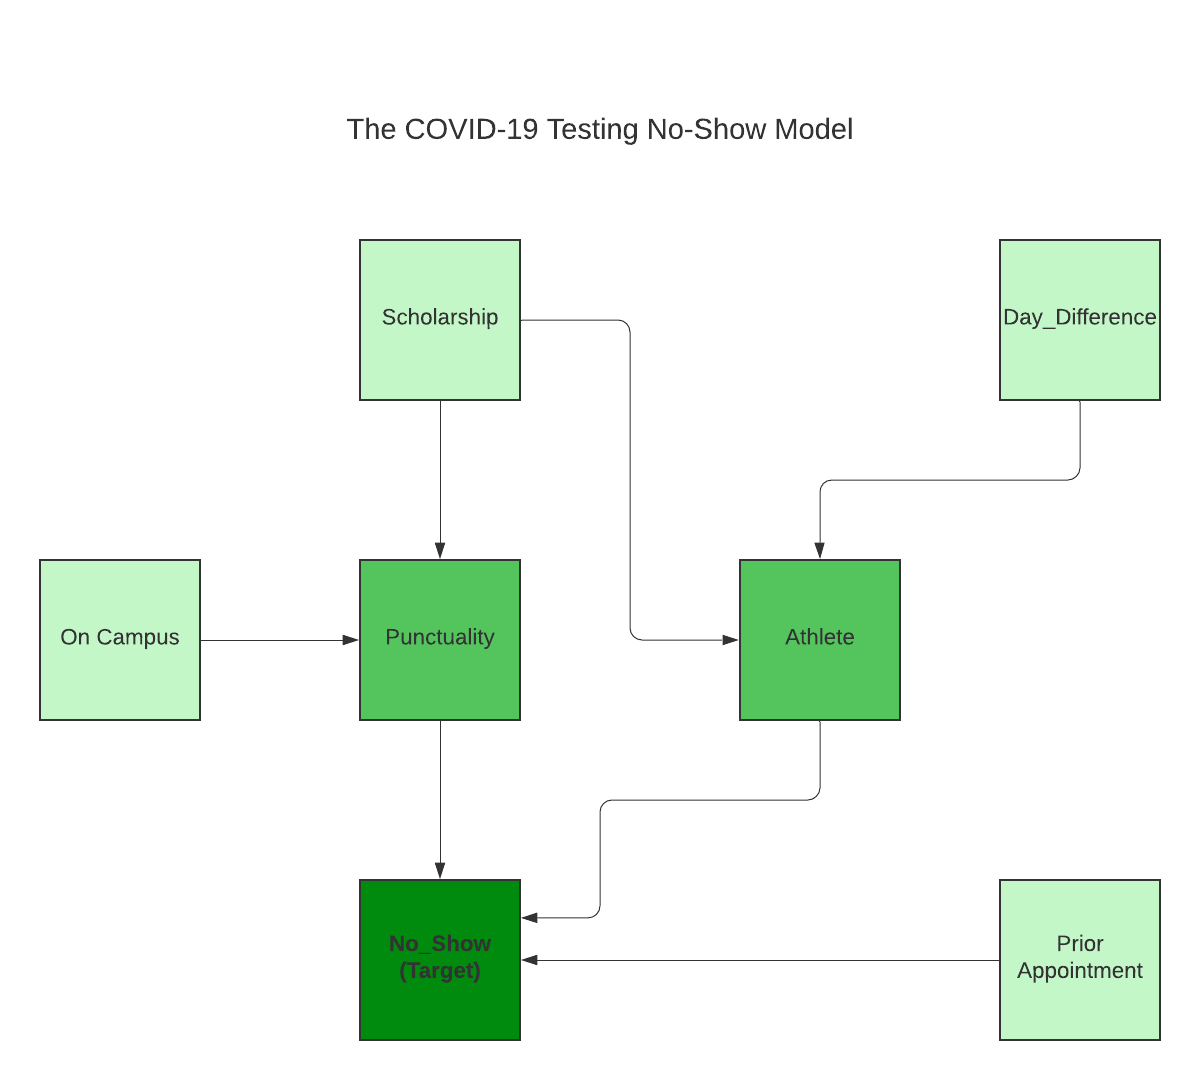

Further, modeling using the BN also require us to acknowledge the underlying Markov property assumption: all dependencies in the network are explicitly shown via the connection between nodes. In our No-Show model, there are no ways for the scholarship to affect "prior appointments" except through the way of causing no-show.

In [ ]:
# install required libraries
!pip install pgmpy
!pip install numpy
!pip install pandas

     |████████████████████████████████| 1.9 MB 8.6 MB/s 


It is simple to define the connections within the using pgmpy. The syntax`('Scholarship', 'Punctuality')` defines an direct connection between scholarship and punctuality. 

In [ ]:
from pgmpy.models import BayesianNetwork

noshow_model = BayesianNetwork(
    [
        ("Scholarship", "Punctuality"),
        ("On campus", "Punctuality"),
        ("Punctuality", "No-Show"),
        ("Scholarship", "Athlete"),
        ("Day difference", "Athlete"),
        ("Athlete", "No-Show"),
        ("Prior appointment", "No-Show")
    ]
)

#### 2.1.2 Define the CPDs

Each node of a Bayesian Network has a conditional probability distribution (CPD) associated with it, hence we need to define 8 CPDs. In each CPD we will define the probability of a node when the value of its parent(s) is known. This nature of the CPD indicates that to achieve direct inference, the size of a CPD table will depend on the number of variables of itself and its parents. For example, a node with m possible values and one parent node with n possible value will have a CPD table of size m * n. One can easily imagine, the size of CPDs growing exponentially large as the network grows more complex. In fact, it is this unmanaged size that makes real-world applications of the Bayesian network challenging [1]. 

In [ ]:
from pgmpy.factors.discrete import TabularCPD

cpd_scholarship = TabularCPD(
    variable="Scholarship",
    variable_card=2,
    values=[[0.3], [0.7]],
    state_names={"Scholarship": ["T","F"]}
)
cpd_campus = TabularCPD(
    variable="On campus",
    variable_card=2,
    values=[[0.85], [0.15]],
    state_names={"On campus": ["T","F"]}
)
cpd_day = TabularCPD(
    variable="Day difference",
    variable_card=3,
    values=[[0.75], [0.2], [0.05]],
    state_names={"Day difference": ["1 day","2 days","3+ days"]}
)
cpd_prior = TabularCPD(
    variable="Prior appointment",
    variable_card=2,
    values=[[0.7], [0.3]],
    state_names={"Prior appointment": ["0-5 times","5+ times"]}
)

cpd_punctual = TabularCPD(
    variable="Punctuality",
    variable_card=2,
    values=[[0.7,0.6,0.5,0.4],
            [0.3,0.4,0.5,0.6]],
    evidence=["Scholarship", "On campus"],
    evidence_card=[2,2],
    state_names={"Punctuality": ["T", "F"],
                 "Scholarship": ["T", "F"],
                 "On campus": ["T", "F"]
                }
)
cpd_athlete = TabularCPD(
    variable="Athlete",
    variable_card=2,
    values = [[0.4,0.5,0.6,0.3,0.4,0.5],
              [0.6,0.5,0.4,0.7,0.6,0.5]],
    evidence=["Scholarship", "Day difference"],
    evidence_card=[2,3],
    state_names={"Athlete": ["T","F"],
              "Scholarship": ["T","F"],
              "Day difference": ["1 day","2 days","3+ days"]
            }
)
cpd_noshow = TabularCPD(
    variable="No-Show",
    variable_card=2,
    values=[[0.1,0.05,0.3,0.2,0.4,0.3,0.5,0.4],
            [0.9,0.95,0.7,0.8,0.6,0.7,0.5,0.6]],
    evidence=["Athlete", "Punctuality", "Prior appointment"],
    evidence_card=[2,2,2],
        state_names={"No-Show": ["T","F"],
              "Athlete": ["T","F"],
              "Punctuality": ["T","F"],
              "Prior appointment": ["0-5 times","5+ times"]
            }
)

#### 2.1.3 Add the CPDs to the model

In [ ]:
# Associating the parameters with the model structure
noshow_model.add_cpds(cpd_athlete, cpd_campus, cpd_day, cpd_noshow, cpd_prior, cpd_punctual, cpd_scholarship)

# Checking if the cpds are valid for the mode
noshow_model.check_model()

True

The check_model method will loop through all CPDs in the No-Show Model and make sure all conditional probability assignments satisfy the requirement, such as if the sum of the probability of a random variable equals 1. So, with the `check_model` function returning True, we can use the model to develop some insight into different reasons for testing no-shows. 

#### 2.1.4 Run basic operations on the model

We can know ask questions related with our variables using the defined Baysian network. For example, we can check is two nodes dconnected using is `is_dconnected()` method. In the code below, for example, the nodes "prior appointment" and "scholarship" are independent with each other, the change in the probability of one of them will not affect the other.

In [ ]:
# Check for d-separation between variables
print(noshow_model.is_dconnected("Prior appointment", "Scholarship"))

False


In [ ]:
# Get all d-connected nodes for specific node
noshow_model.active_trail_nodes("On campus")

{'On campus': {'No-Show', 'On campus', 'Punctuality'}}

After looking at different independencies, we can also use the model to infer the probability of No-Show happening when we introduce specific evidence into the model using the code sequence below:

In [ ]:
# create inference variable that uses variable elimination internally for inference
from pgmpy.inference import VariableElimination
inference = VariableElimination(noshow_model)

# find probability of "No-Show"
result = inference.query(variables=['No-Show'])
print("No-Show\n", result)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

No-Show
 +------------+----------------+
| No-Show    |   phi(No-Show) |
+============+================+
| No-Show(T) |         0.3265 |
+------------+----------------+
| No-Show(F) |         0.6735 |
+------------+----------------+


As shown above, the variable elimination algorithm to perform exact inference on the variable in query "No-Show". In general, the variable elimination algorithm allows us to compute the marginal probability of the query variable by first calculating the partition function, then computing marginal using unnormalized distribution, and finally dividing the result by the partition function to get the normalized probability distribution [4].

In [ ]:
# compare probability of "No-Show" given the student received scholarship
result = inference.query(variables=["No-Show"], evidence={'Scholarship': "T"})
print("No-Show | Scholarship=T \n", result)

result = inference.query(variables=["No-Show"], evidence={'Scholarship': "F"})
print("No-Show | Scholarship=F \n", result)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

No-Show | Scholarship=T 
 +------------+----------------+
| No-Show    |   phi(No-Show) |
+============+================+
| No-Show(T) |         0.2905 |
+------------+----------------+
| No-Show(F) |         0.7095 |
+------------+----------------+


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

No-Show | Scholarship=F 
 +------------+----------------+
| No-Show    |   phi(No-Show) |
+============+================+
| No-Show(T) |         0.3419 |
+------------+----------------+
| No-Show(F) |         0.6581 |
+------------+----------------+


An equally interesting problem is computing the conditional probability with given evidence. We can compute the probability by performing the above variable elimination algorithm once on the joint distribution, and once on the probability of the variable itself. As shown by our particular example, the conditional probability of No-Show given a student has received a scholarship is 0.2905 which is smaller than the probability of no-show given a student did not receive a scholarship. This result is consistent with the general observation made earlier. Hence, our network has correctly incorporated the knowledge given earlier. 

2.2 Model Evaluation

For simplicity reasons, we will limit the set of nodes and values specified above. The limitation in variable range poses limitations to our network. For instance, there is no representation of no-shows likelihood for other types of appointments like writing center meetings. Another limitation is the lack of differentiation, for example between full or half scholarship recipients, and the model assumes there is no difference in commitment likelihood between students who schedule their tests a week earlier and those who schedule 4 days earlier.

## 3. Parameter Learning in BN

As described above, the Bayesian network has two components: the graph structure and the conditional probability distribution associated with each node. This property poses an opportunity for parameter learning, where the structure of the network is given and we want to estimate the factors.

The objective of the learning task is to find the model that best captures the underlying distribution of the true model. In this case, instead of the true CPD table definition, we first sample some data from the no-show model, then try to estimate the underlying distribution from the data points.

We use the sampling method to generate our data set. The sampling process basically involves the algorithms creating random events, where hopefully the result will screw towards the value category that has the highest possibility. Using the sampling method, we are able to generate 1,000,000 data points.

In [ ]:
# Step 1: Generate data points

# use the no-show model to generate data from it

from pgmpy.sampling import BayesianModelSampling

samples = BayesianModelSampling(noshow_model).forward_sample(size=int(1e6))
samples.head()

  0%|          | 0/7 [00:00<?, ?it/s]

,Scholarship,Punctuality,On campus,No-Show,Athelet,Day difference,Prior appointment
0,T,F,T,F,F,2 days,5+ times
1,T,T,T,T,F,1 day,0-5 times
2,F,F,T,F,F,1 day,0-5 times
3,T,F,T,F,F,3+ days,0-5 times
4,F,F,T,T,T,1 day,0-5 times


Next, since in our training case, the structure of the network is defined, we copy the connections defined in the noshow_model. The 'model_struct.nodes()' method confirmed that we are operating with the same set of nodes. 

In [ ]:
# Step 2: Define a model structure

# Defining the Bayesian Model structure

from pgmpy.models import BayesianNetwork

model_struct = BayesianNetwork(ebunch=noshow_model.edges())
model_struct.nodes()

NodeView(('Scholarship', 'Punctuality', 'Athelet', 'No-Show', 'On campus', 'Day difference', 'Prior appointment'))

Finally, we use the 'MaximumLikelihoodEstimator' class to estimate the full distrubution of the network so that we can later use variable elimination to calculate the conditional probability of specific nodes.

In [ ]:
# Step 3: Learning the model parameters

# Fitting the model using Maximum Likelihood Estimator

from pgmpy.estimators import MaximumLikelihoodEstimator

estimator = MaximumLikelihoodEstimator(model=model_struct, data=samples)

ModuleNotFoundError: ignored

In [ ]:
# Step 4: Model evaluation

# Calculate mean error
import pandas as pd
(noshow_model.get_cpds("No-Show").values - estimator.estimate_cpd("No-Show").values).mean()

0.6002315708220763

With the maximum likelihood in hand, we can compare the estimated distribution at our target node "No-Show" with the actual value we put in ealier. The mean error is around 0.6 or 60%, which is pretty high considering the maximum discrepency is 100%. This error value can be caused by several reasons, one of them is the structure of the model. Close inspection of the predicted value shows that the estimator assign very high weights for specific value pairs, which can be a sign of **overfitting**. Since, the structure of the model is fairly linear, nodes such as "Scholarship" will have stronger predictive power than other nodes, which can explain why the estimator switch between large and small weights whenever the value of scholarship change between 'T' and 'F'.

## 4. Summary

In this mini-project, we have applied probabilistic graphical model - specifically Baysian networks - to model the no-show likelyhood. By taking advantage of the pgmpy library, a series of model related tasks are performed: including independencies, probability query, conditional probability query, and model parameter learning. Specifically, we can oberve that our model performed well in independecy and conditional probability queries, where we are able to get an exact answer or inference. The error increased greatly, however, when it comes to the learning task which is probably due to the structure of the model. Through learning the methods and applications of Probabilistic Graphical Models over this semster, I realized its tremendous real-world implecations and hope to explore more details methods and tasks in the future.

## 5. Citation
[1]. A. Ankan and A. Panda, “Pgmpy: Probabilistic graphical models using Python,”

[2]. Proceedings of the 14th Python in Science Conference, 2015. 
D. Koller and N. Friedman, Probabilistic graphical models principles and Techniques. MIT Press, 2012. 

[3]. J. Brownlee, “A gentle introduction to Bayesian Belief Networks,” Machine Learning Mastery, 24-Sep-2019. [Online]. Available: https://machinelearningmastery.com/introduction-to-bayesian-belief-networks/. [Accessed: 07-Feb-2022]. 

[4]. V. Kuleshov and S. Ermon, “CS228,” ermongroup. [Online]. Available: https://ermongroup.github.io/cs228-notes/. [Accessed: 07-Feb-2022]. 